# Принятие решений в бизнесе

## Описание проекта

<ins>Контекст</ins>:

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

<ins>Структура предоставленных данных</ins>:
- Структура **hypothesis.csv**:
    - *Hypothesis* — краткое описание гипотезы;
    - *Reach* — охват пользователей по 10-балльной шкале;
    - *Impact* — влияние на пользователей по 10-балльной шкале;
    - *Confidence* — уверенность в гипотезе по 10-балльной шкале;
    - *Efforts* — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.
- Структура **orders.csv**:
    - *transactionId* — идентификатор заказа;
    - *visitorId* — идентификатор пользователя, совершившего заказ;
    - *date* — дата, когда был совершён заказ;
    - *revenue* — выручка заказа;
    - *group* — группа A/B-теста, в которую попал заказ.
- Структура **visitors.csv**:
    - *date* — дата;
    - *group* — группа A/B-теста;
    - *visitors* — количество пользователей в указанную дату в указанной группе A/B-теста

<ins>Предварительный план решения</ins>:
1. Выполнить обзор данных;
2. Предобработать данные;
3. При помощи фреймворков ICE и RICE приоретизировать список гипотез и определить лучшую гипотезу для тестирования;
4. Проанализировать результаты A/B теста;
5. Сделать финальный вывод.

## 1. Обзор данных:

In [1]:
# Подключаем необходимые библиотеки:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime as dt
import scipy.stats as st

In [2]:
# Считываем полученные данные:
try:
    hypothesis = pd.read_csv('hypothesis.csv')
    orders = pd.read_csv('orders.csv')
    visitors = pd.read_csv('visitors.csv')
except:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')  

In [3]:
# Посмотрим на содержание предоставленных датафреймов:
display(hypothesis.head())
display(orders.head())
display(visitors.head())

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [4]:
# Проверим данные на наличие пропусков, а также на соответствие типов:
display(hypothesis.info())
display(orders.info())
display(visitors.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

In [5]:
# Проверим данные на аномальные значения:
display(hypothesis.describe())
display(orders.describe())
display(visitors.describe())

,Reach,Impact,Confidence,Efforts
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


### Краткий вывод по итогам секции:
- Название колонок не соответствует стилю 'snake_case';
- Тип данных в столбцах, содержащих информацию о времени события, не соответсвуют типу datetime;

## 2. Предобработка данных

### 2.1 Приведение названий столбцов к стилю 'snake_case'

In [6]:
hypothesis.columns = hypothesis.columns.str.lower()

orders = orders.rename(columns = {'transactionId' : 'transaction_id',
                                  'visitorId' : 'visitor_id'})

### 2.2 Обработка дубликатов

In [7]:
# Посчитаем количество полных дубликатов в каждом датафрейме:
display(hypothesis.duplicated().sum())
display(orders.duplicated().sum())
display(visitors.duplicated().sum())

0

0

0

In [8]:
# Проверим данные на наличие неявных дубликатов:

In [9]:
display(hypothesis['hypothesis'].unique())
display(orders['group'].unique())
display(visitors['group'].unique())

array(['Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей',
       'Запустить собственную службу доставки, что сократит срок доставки заказов',
       'Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа',
       'Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар',
       'Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей',
       'Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов',
       'Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию',
       'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок',
       'Запустить акцию, дающую скидку на товар в день рождения'],
      dtype=object)

array(['B', 'A'], dtype=object)

array(['A', 'B'], dtype=object)

### 2.3 Приведение данных к нужным типам:

In [10]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

### 2.4 Проверка разбиения пользователей при проведении A/B теста:

In [11]:
# Проверим, существуют ли пользователи, которые попали в обе группы одновременно:
users_in_both_groups = (orders.query('group=="A"')
                        .merge(orders.query('group=="B"'),how='inner',on='visitor_id')['visitor_id']
                        .drop_duplicates()
                       )
print("Количество уникальных пользователей, попавших в обе группы: {}".format(users_in_both_groups.shape[0]))

Количество уникальных пользователей, попавших в обе группы: 58


In [12]:
# Исключим этих пользователей из нашего анализа:
orders = orders[np.logical_not(orders['visitor_id'].isin(users_in_both_groups))]

### Краткий вывод по итогам секции:
- названия столбцов были приведены к стилю 'snake_case',
- в датафреймах отсутствуют как полные, так и неявные дубликаты,
- данные в стобцах, содержащих информацию о времени того или иного события, были приведены к типу datetime;
- из датафрейма orders были удалены пользователи, которые попали в обе группы для тестирования одновременно.

## 3. Приоритизация списка гипотез

In [13]:
# Рассчитаем метрики 'ICE' и 'RICE' для приоритизации гипотез:
hypothesis['ice'] = round(hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'], 2)
hypothesis['rice'] = round(hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'], 2)

In [14]:
# Отсортируем гипотезы по метрике 'ICE':
pd.options.display.max_colwidth = 1
hypothesis[['hypothesis', 'ice', 'rice']].sort_values(by = 'ice', ascending = False)

,hypothesis,ice,rice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20,112.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00,40.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00,56.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33,4.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00,3.0


Исходя из фреймворка 'ICE', самыми перспективными гипотезами являются гипотезы с индексами 8, 0, 7, а именно:
1. Запустить акцию, дающую скидку на товар в день рождения;
2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
3. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;

In [15]:
# Отсортируем гипотезы по метрике 'RICE':
hypothesis[['hypothesis', 'ice', 'rice']].sort_values(by = 'rice', ascending = False)

,hypothesis,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00,3.0


Исходя из фреймворка 'RICE', самыми перспективными гипотезами являются гипотезы с индексами 7, 2, 0 а именно:
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;

### Краткий вывод по итогам приоритизации гипотез:
- Поскольку целью данного исследования является увеличение суммарной выручки компании, необходимо уделить большее внимание метрике 'RICE' при выборе гипотезы для проведения A/B теста. Тк именно 'RICE' (в отличии от метрики 'ICE') учитывает охват гипотезы.
- Лучшей гипотезой для тестирования является гипотеза под индексом 7:
    - *Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок*;

## 4. Анализ результата A/B теста

### 4.1 Анализ кумулятивной выручки по группам.

In [16]:
# Рассчитаем кумулятивные параметры:
datesGroups = orders[['date','group']].drop_duplicates()
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'],
                                    orders['group'] == x['group'])]
    .agg({'date' : 'max',
          'group' : 'max',
          'transaction_id' : 'nunique',
          'visitor_id' : 'nunique',
          'revenue' : 'sum'}), axis=1) \
    .sort_values(by=['date','group'])

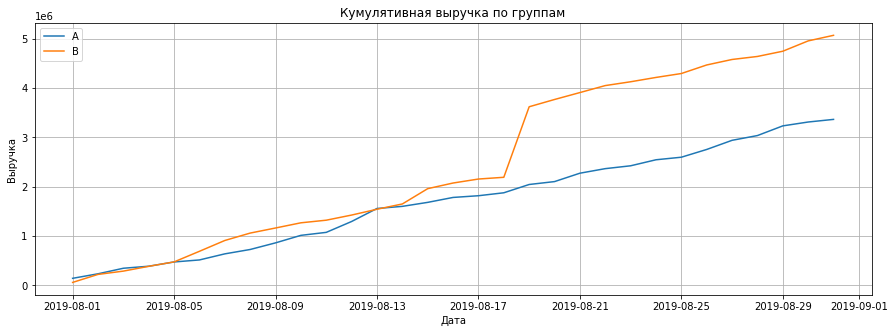

In [17]:
# Построим графики кумулятивной выручки по группам:
plt.figure(figsize = (15, 5))
plt.plot(ordersAggregated.query('group == "A"')['date'], ordersAggregated.query('group == "A"')['revenue'], label = "A")
plt.plot(ordersAggregated.query('group == "B"')['date'], ordersAggregated.query('group == "B"')['revenue'], label = "B")
plt.legend()
plt.title("Кумулятивная выручка по группам")
plt.xlabel("Дата")
plt.ylabel("Выручка")
plt.grid()

#### Краткий анализ кумулятивной выручки по группам:
- Начиная с 2019-08-19 выручка пользователей из группы B стала стабильно превышать выручку пользователей из группы А.
- Однако, если анализировать ситуацию после трёх недель после начала теста, можно заметить, что прямая кумулятивной выручки для группы B практически параллельна прямой кумулятивной выручки для группы А. Это говорит о том, что выручка группы B растёт примерно с той же скоростью, что и выручка группы А.
- Превышение же выручки группы B над А можно объяснить аномально большими заказами в группе B с 2019-08-17 по 2019-08-21.
- Таким образом, без анализа аномальных значений нельзя говорить о успешности A/B теста.

### 4.2 Анализ кумулятивного среднего чека по группам.

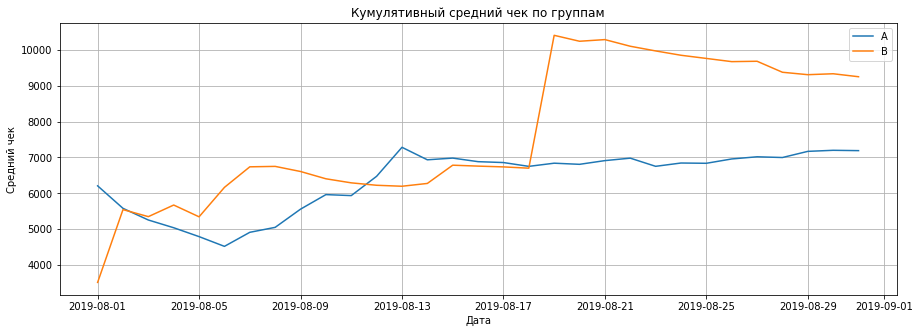

In [18]:
# Построим графики кумулятивного среднего чека по группам:
plt.figure(figsize = (15, 5))
plt.plot(ordersAggregated.query('group == "A"')['date'], ordersAggregated.query('group == "A"')['revenue'] / ordersAggregated.query('group == "A"')['transaction_id'], label = "A")
plt.plot(ordersAggregated.query('group == "B"')['date'], ordersAggregated.query('group == "B"')['revenue'] / ordersAggregated.query('group == "B"')['transaction_id'], label = "B")
plt.legend()
plt.title("Кумулятивный средний чек по группам")
plt.xlabel("Дата")
plt.ylabel("Средний чек")
plt.grid()

#### Краткий вывод по итогам расчёта кумулятивного среднего чека по группам:
- После двух с половиной недель активных колебаний средний чек группы А начал потихоньку стабилизироваться вокруг значения в 7000.
- Динамика среднего чека группы B на начальном этапе похожа на динамику среднего чека группы A: первые две с половиной недели характеризовались активными колебаниями, потом началась фаза стабилизации, которая, однако, прервалась резким увеличением среднего чека в полтора раза.
- Вероятней всего, резкий скачок вызван попаданием в группу B аномально больших заказов (аномалий). Последующее плавное снижение среднего чека группы B свидетельствует в пользу высказанного выше предположения.
- Для того чтобы судить о успешности A/B теста, необходимо повторить исследование, предварительно исключив из данных аномальные заказы.

### 4.3 Анализ относительного изменения кумулятивного среднего чека группы B к группе A. 

In [19]:
# Подготовим данные для построения графика:
merged_cumulative_data = (ordersAggregated.query('group == "B"')
                          .merge(ordersAggregated.query('group == "A"'),
                                 on = 'date',
                                 how = 'inner')
                         )

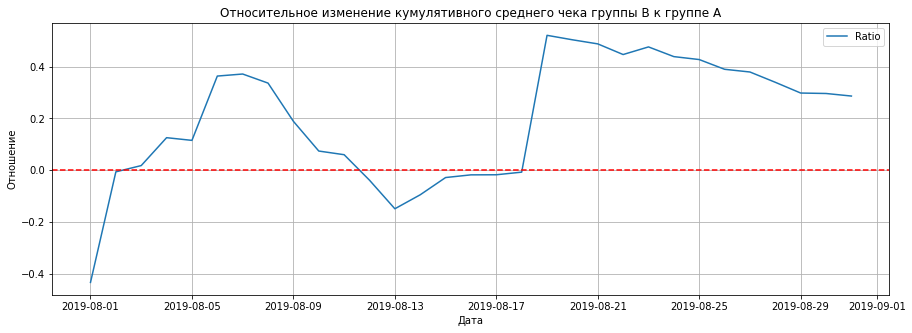

In [20]:
# Построим график относительного среднего чека группы B к группе A:
plt.figure(figsize = (15, 5))
plt.plot(merged_cumulative_data['date'], (merged_cumulative_data['revenue_x'] / merged_cumulative_data['transaction_id_x']) / (merged_cumulative_data['revenue_y'] / merged_cumulative_data['transaction_id_y']) - 1, label = "Ratio")
plt.legend()
plt.title("Относительное изменение кумулятивного среднего чека группы B к группе A")
plt.xlabel("Дата")
plt.ylabel("Отношение")
plt.grid()
plt.axhline(y=0, color='red', linestyle='--')

#### Краткий вывод по итогам расчёта отношения кумулятивного среднего чека группы B к группе А:
- Полученный график илюстрирует все те тенденции, которые были подмечены в прошлом выводе:
    - с 2019-08-01 по 2019-08-15 кумулятивные чеки групп A и B колебались с достаточно большой амплитудой;
    - с 2019-08-15 началась фаза стабилизации средних чеков, которая была прервана взлетом среднего чека группы B;
    - с 2019-08-21 отношение кумулятивного среднего чека группы B к кумулятивному среднему чеку группы А начинает стабильно снижаться;
- Очевидно, что для более точных выводов необходимо посмотреть на ситуацию, избавившись от аномалий.

### 4.4 Анализ кумулятивного среднего количества заказов на посетителя по группам.

In [21]:
# Рассчитаем кумулятивное количество посетителей:
visitorsAggregated = (datesGroups
                      .apply(
                          lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
                          .agg({'date' : 'max',
                                'group' : 'max',
                                'visitors' : 'sum'}), axis=1)
                     )
ordersAggregated = ordersAggregated.merge(
    visitorsAggregated, on = ['date', 'group'], how = 'left')

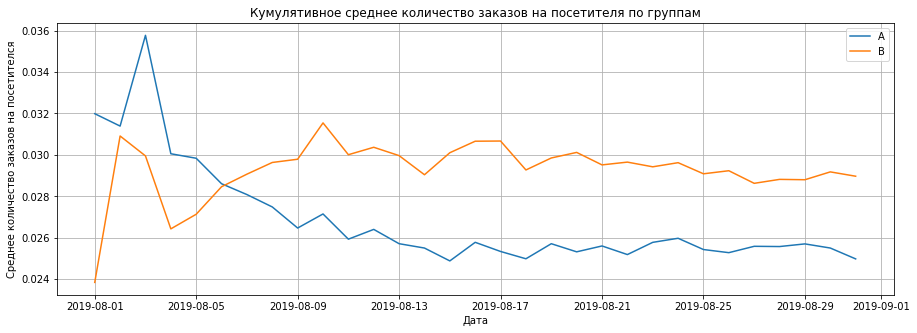

In [22]:
# Построим графики кумулятивного среднего количества заказов на посетителя по группам:
plt.figure(figsize = (15, 5))
plt.plot(ordersAggregated.query('group == "A"')['date'], ordersAggregated.query('group == "A"')['transaction_id'] / ordersAggregated.query('group == "A"')['visitors'], label = "A")
plt.plot(ordersAggregated.query('group == "B"')['date'], ordersAggregated.query('group == "B"')['transaction_id'] / ordersAggregated.query('group == "B"')['visitors'], label = "B")
plt.legend()
plt.title("Кумулятивное среднее количество заказов на посетителя по группам")
plt.xlabel("Дата")
plt.ylabel("Среднее количество заказов на посетителся")
plt.grid()

#### Краткий вывод по итогам расчёта кумулятивного среднего количества заказов на посетителя:
- В первые дни после начала A/B теста метрики для групп A и B сильно колебались, периодически превышая друг друга;
- Примерно через неделю после старта метрики начали стабилизироваться;
- По прошествию месяца с начала теста можно с уверенностью говорить, что кумулятивное среднее количество заказов на посетителя для группы B стабильно выше чем для группы А.

### 4.5 Анализ относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. 

In [23]:
# Подготовим данные для визуализации отношения кумулятивного среднего количества
# заказов на посетителя группы В к группе А:
merged_cumulative_data = ordersAggregated.query('group == "A"').merge(
    ordersAggregated.query('group == "B"'),
    on = 'date',
    how = 'left')

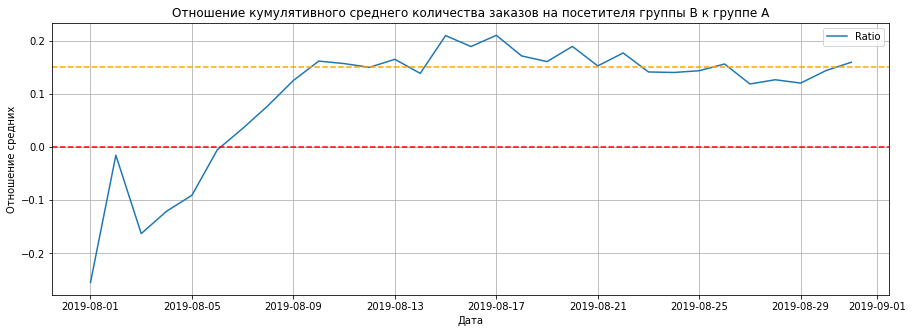

In [24]:
# Построим график отношения кумулятивного среднего количества заказов на посетителя группы В к группе А:
plt.figure(figsize = (15, 5))
plt.plot(merged_cumulative_data['date'], (merged_cumulative_data['transaction_id_y'] / merged_cumulative_data['visitors_y']) / (merged_cumulative_data['transaction_id_x'] / merged_cumulative_data['visitors_x']) - 1, label = "Ratio")
plt.legend()
plt.title("Отношение кумулятивного среднего количества заказов на посетителя группы В к группе А")
plt.xlabel("Дата")
plt.ylabel("Отношение средних")
plt.grid()
plt.axhline(y=0, color='red', linestyle='--')
plt.axhline(y=0.15, color='orange', linestyle='--')

#### Краткий вывод по итогам расчета отношения кумулятивного среднего количества заказов на посетителя группы В к группе А:
- После начальных колебаний, продлившигся примерно десять дней после старта теста, рассчитанное отношение стабилизировалось;
- Итого, кумулятивное среднее количество заказов на посетителся для группы B больше аналогичного показателя для группы А примерно на 15%.

### 4.6 Анализ количества заказов по пользователям.

In [25]:
orders_scatter = orders.groupby('visitor_id', as_index = False).agg({'transaction_id' : 'nunique'})
x_values = pd.Series(range(0, len(orders_scatter['transaction_id'])))

Text(0.5, 0, 'Порядковый номер пользователя')

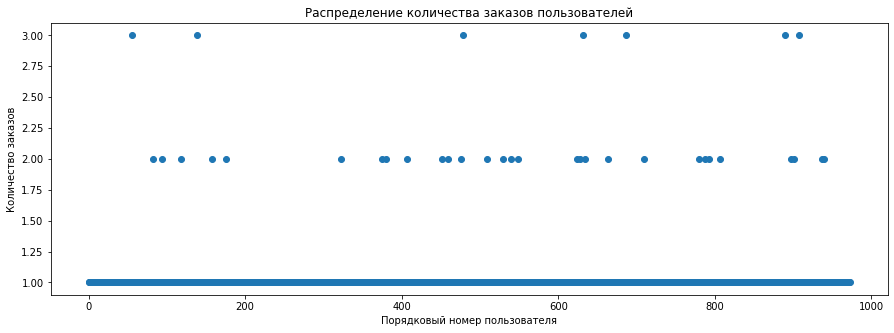

In [26]:
plt.figure(figsize = (15, 5))
plt.scatter(x_values, orders_scatter['transaction_id'])
plt.title("Распределение количества заказов пользователей")
plt.ylabel('Количество заказов')
plt.xlabel('Порядковый номер пользователя')

#### Анализ распределения количества заказов пользователей:
- Большая часть пользователей совершает заказ один единственный раз;
- Совсем небольшая часть пользователей совершает заказ от двух до пяти раз;
- И лишь совсем мизерная доля пользователей совершает больше пяти заказов;

### 4.7 Расчёт 95-ого и 99-ого перцентиля количества заказов на пользователя. Выбор границы для определения аномальных пользователей.

In [27]:
# Рассчитаем 90-й, 95-й и 99-й перцентили количества заказов на пользователя
print(np.percentile(orders_scatter['transaction_id'], [90, 95, 99]))

[1. 1. 2.]


#### Выбор границы для определения аномальных пользователей:
- Доля пользователей, совершивших более двух заказов составляет 5%;
- Доля пользователей, совершивших более четырех заказов, составляет 1%;
- Будем считать пользователей, совершивших три и более заказов, аномальными.

### 4.8 Анализ распределения стоимостей заказов.

Text(0.5, 0, 'Порядковый номер транзакции')

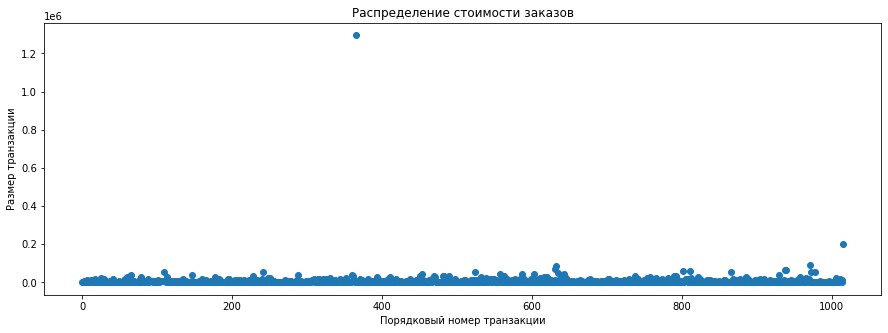

In [28]:
# Построим график распределения стоимостей заказов:
plt.figure(figsize = (15, 5))
plt.scatter(pd.Series(range(0, len(orders['revenue']))), orders['revenue'])

plt.title("Распределение стоимости заказов")
plt.ylabel('Размер транзакции')
plt.xlabel('Порядковый номер транзакции')

(0.0, 100000.0)

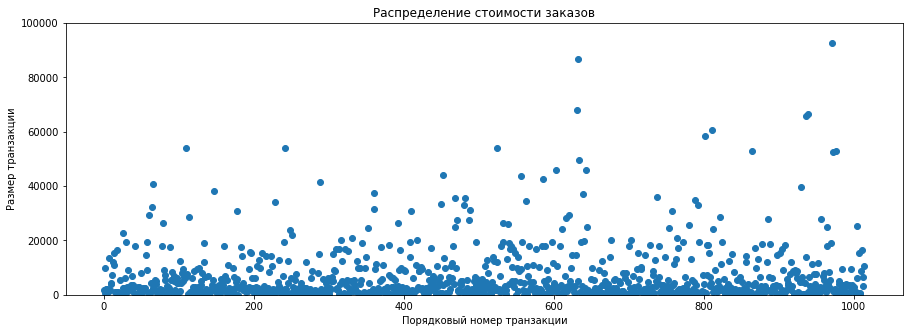

In [29]:
# Построим тот же график, уменьшив область значений:
plt.figure(figsize = (15, 5))
plt.scatter(pd.Series(range(0, len(orders['revenue']))), orders['revenue'])

plt.title("Распределение стоимости заказов")
plt.ylabel('Размер транзакции')
plt.xlabel('Порядковый номер транзакции')
plt.ylim(0, 100000)

#### Анализ распределения стоимости заказов:
- Стоимость большей части заказов укладывается в диапазон от нуля до пятидесяти тысяч;
- В выборку попали заказы с аномальной для нашей выборки стоимостью: один заказ стоимостью более миллиона рублей, другой заказ стоимостью примерно в двести тысяч.

### 4.9 Расчёт 95-ого и 99-ого перцентиля стоимости заказов. Выбор границы стоимости для определения аномальных заказов.

In [30]:
# Рассчитаем 90-й, 95-й и 99-й перцентили стоимости заказов:
print(np.percentile(orders['revenue'], [90, 95, 99]))

[17990. 26785. 53904.]


#### Выбор границы стоимости для определения аномальных заказов:
- Стоимость лишь 5% заказов превышает 28000;
- Стоимость лишь 1% заказов превышает 58000;
- Будем считать заказы, стоимость которых превышает 28000, аномальными.

### 4.10 Расчёт статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

Cтатистическую значимость различий в среднем количестве заказов на посетителся между группами будем считать при помощи критерия Манна-Уитни. 

Для этого необходимо для каждой группы посчитать уникальное количество заказов для каждого пользователя.

In [31]:
# Считаем для каждой группы количество заказов,
# которые совершил каждый уникальный пользователь:
sampleA = (orders.query('group == "A"')
                 .groupby('visitor_id', as_index = False)
                 .agg({'transaction_id' : 'nunique'})
          )

sampleB = (orders.query('group == "B"')
                 .groupby('visitor_id', as_index = False)
                 .agg({'transaction_id' : 'nunique'})
          )

In [32]:
# Собираем серию из пользователей, которые совершили хотя бы один заказ,
# c теми кто ни разу не совершал покупку: 
sampleA = pd.concat([sampleA['transaction_id'], pd.Series(0, index = np.arange(visitors.query('group == "A"')['visitors'].sum() - sampleA['visitor_id'].nunique()))])
sampleB = pd.concat([sampleB['transaction_id'], pd.Series(0, index = np.arange(visitors.query('group == "B"')['visitors'].sum() - sampleB['visitor_id'].nunique()))])

#### Формулировка гипотез:
- *Нулевая гипотеза* ${H_{0}}$: среднее количество заказов на посетителя групп А и B равно друг другу; 
- *Альтернативная гипотеза* ${H_{1}}$: среднее количество заказов на посетителя групп А и B различно; 

In [33]:
# Выполним расчёт критерия Манна-Уитни:
alpha = 0.05
print('Значение p-value: {:.7f}'.format(st.mannwhitneyu(sampleA, sampleB)[1]))

if st.mannwhitneyu(sampleA, sampleB)[1] < alpha:
    print("Отвергаем нулевую гипотезу")
    print('Относительный прирост среднего кол-ва заказов на пользователя группы  B над группой А составил: {:.2%}'.format(sampleB.mean() / sampleA.mean() - 1))
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Значение p-value: 0.0110181
Отвергаем нулевую гипотезу
Относительный прирост среднего кол-ва заказов на пользователя группы  B над группой А составил: 15.98%


#### Анализ стат. теста Манна-Уитни на сырых данных:
- Нулевую гипотезу о равенстве среднего количества заказов на пользователях в группах A и B отвергаем;
- Относительный прирост среднего кол-ва заказов на пользователя группы  B над группой А составил: 15.98%;
- К полученным результатам необходимо относиться настороженно, так как в данных присутствовали выбросы;

### 4.11 Расчёт статистической значимости различий в среднем чеке заказа между группами по «сырым» данным.

#### Формулировка гипотез:
- *Нулевая гипотеза* ${H_{0}}$: средние чеки заказов для групп А и B равны друг другу; 
- *Альтернативная гипотеза* ${H_{1}}$: средние чеки заказов для групп А и B различны; 

In [34]:
# Выполним расчёт критерия Манна-Уитни:
print('Значение p-value: {:.7f}'.format(st.mannwhitneyu(orders.query('group == "A"')['revenue'], orders.query('group == "B"')['revenue'])[1]))

if st.mannwhitneyu(orders.query('group == "A"')['revenue'], orders.query('group == "B"')['revenue'])[1] < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
print('Относительный прирост среднего чека группы  B над группой А составил: {:.2%}'.format(sampleB.mean() / sampleA.mean() - 1))

Значение p-value: 0.8294909
Не получилось отвергнуть нулевую гипотезу
Относительный прирост среднего чека группы  B над группой А составил: 15.98%


##### Анализ стат. теста:
- p_value получился очень большим, следовательно мы не может отвергнуть нулевую гипотезу.

<div class="alert alert-info">  Исправил.</div>

### 4.12 Расчёт статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

In [35]:
# Составим список аномальных пользователей:
abnormal_users = orders_scatter.query('transaction_id > 2')['visitor_id']
abnormal_users = (pd.concat([abnormal_users, orders.query('revenue > 28000')['visitor_id']])
                      .drop_duplicates()
                 )

In [36]:
# Выполним очистку данных:
orders_cleaned = orders[np.logical_not(orders['visitor_id'].isin(abnormal_users))]

In [37]:
# Считаем для каждой группы количество заказов,
# которые совершил каждый уникальный пользователь:
sampleA = (orders_cleaned.query('group == "A"')
                 .groupby('visitor_id', as_index = False)
                 .agg({'transaction_id' : 'nunique'})
          )

sampleB = (orders_cleaned.query('group == "B"')
                 .groupby('visitor_id', as_index = False)
                 .agg({'transaction_id' : 'nunique'})
          )

In [38]:
# Собираем серию из пользователей, которые совершили хотя бы один заказ,
# c теми кто ни разу не совершал покупку (с учетом аномальных пользователей): 
sampleA = pd.concat([sampleA['transaction_id'], pd.Series(0, index = np.arange(visitors.query('group == "A"')['visitors'].sum() - sampleA['visitor_id'].nunique() - len(abnormal_users)))])
sampleB = pd.concat([sampleB['transaction_id'], pd.Series(0, index = np.arange(visitors.query('group == "B"')['visitors'].sum() - sampleB['visitor_id'].nunique() - len(abnormal_users)))])

#### Формулировка гипотез:
- *Нулевая гипотеза* ${H_{0}}$: среднее количество заказов на посетителя групп А и B равно друг другу; 
- *Альтернативная гипотеза* ${H_{1}}$: среднее количество заказов на посетителя групп А и B различно; 

In [39]:
# Выполним расчёт критерия Манна-Уитни:
alpha = 0.05
print('Значение p-value: {:.7f}'.format(st.mannwhitneyu(sampleA, sampleB)[1]))

if st.mannwhitneyu(sampleA, sampleB)[1] < alpha:
    print("Отвергаем нулевую гипотезу")
    print('Относительный прирост среднего кол-ва заказов на пользователя группы  B над группой А составил: {:.2%}'.format(sampleB.mean() / sampleA.mean() - 1))
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Значение p-value: 0.0094804
Отвергаем нулевую гипотезу
Относительный прирост среднего кол-ва заказов на пользователя группы  B над группой А составил: 18.85%


#### Анализ результатов стат. теста Манна-Уитни:
- Результат теста на очищенных данных не изменился: отвергаем нулевую гипотезу.
- Относительный прирост среднего кол-ва заказов на пользователя группы  B над группой А составил: 18.85% (15,98% на неочищенных данных).

### 4.13 Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.

#### Формулировка гипотез:
- *Нулевая гипотеза* ${H_{0}}$: средние чеки заказов для групп А и B равны друг другу; 
- *Альтернативная гипотеза* ${H_{1}}$: средние чеки заказов для групп А и B различны; 

In [40]:
# Выполним расчёт критерия Манна-Уитни:
print('Значение p-value: {:.7f}'.format(st.mannwhitneyu(orders_cleaned.query('group == "A"')['revenue'], orders_cleaned.query('group == "B"')['revenue'])[1]))

if st.mannwhitneyu(orders_cleaned.query('group == "A"')['revenue'], orders_cleaned.query('group == "B"')['revenue'])[1] < alpha:
    print("Отвергаем нулевую гипотезу")
    
else:
    print("Не получилось отвергнуть нулевую гипотезу")

print('Относительный прирост среднего чека группы  B над группой А составил: {:.2%}'.format(orders_cleaned.query('group == "B"')['revenue'].mean() / orders_cleaned.query('group == "A"')['revenue'].mean() - 1))    

Значение p-value: 0.7616881
Не получилось отвергнуть нулевую гипотезу
Относительный прирост среднего чека группы  B над группой А составил: -2.24%


#### Анализ результатов стат. теста Манна-Уитни:
- Результат теста на очищенных данных не изменился: не удалось отвергнуть нулевую гипотезу.

## Итоговый вывод:

В начале исследования, нам необходимо было выбрать одну из девяти перспективных гипотез, которые были подготовлены совместно с отделом маркетинга, для проведения A/B теста.

Гипотезы приоретизировались исходя из поставленной цели - увеличение выручки компании. Для ранжирования гипотез мы обратились к двум фреймворкам приоритизации гипотез - ICE и RICE.

В итоге мы отдали предпочтение фреймворку RICE, тк в отличии от ICE он учитывает охват пользователей, тем самым более точно ранжируя гипотезы под нашу задачу. Победителем стала следующая гипотеза: 

**«Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.»**

По результатам A/B теста были получены следующие выводы:
- Кумулятивная выручка группы B больше кумулятивной выручки группы А;
- Кумулятивный средний чек группы B больше кумулятивного среднего чека группы А;
- Кумулятивное среднее количество заказов на пользователя в группе B больше такого же показателя в группе А;

После была проведена проверка полученных результатов на статистическую значимость. Были получены следующие результаты:
-  Статистически значимых различий в среднем чеке между группами нет, как на обычных данных, так и на данных, избавленных от аномалий;
- Утверждение о том, что кумулятивное среднее количество заказов на пользователя в группе B больше такого же показателя в группе А статистически значимо. Это было показано как на обычных данных, так и на данных, очищенных от аномалий.

Итого, мы можем принять решение об остановке теста. Группа B победила, **следует принять проверяемую гипотезу**.